# Lab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [22]:
#Set global variables
#Variables for file and school informaiton

YEARS = ['2014', '2015', '2016', '2017']
SCHOOLS = ['High','Middle','Elementary']

#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [100, 200, "all"]

#Alpha and C we will be using for our classifiers

C_ESTIMATORS = [50, 100, 200, 500]
C_DEPTH = [2, 3, 5]

#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random


#from umap.umap_ import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

%%html
<style>
table {float:left}
</style>

# 1.a Data Preparation
10 points - Deﬁne and prepare your class variables. Use proper variable 
representations (int, ﬂoat, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for 
the analysis.

# The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools
Our data set originates from the North Carolina Public Schools Reports and Statistics. This public site contains large amounts of information covering many aspects of the performance of students and schools across the state of North Carolina. It includes public and charter schools ranging from the elementary level to high schools. http://www.ncpublicschools.org/

The data used in our lab consists of portions of this data which includes the school years 2014-2017. The data used is the result of combining and cleaning the raw data sets available on the North Carolina website. The machine learning data sets are broken down by school year and then sub-setted by elementary school, middle school and high school information. 

In this lab our data set consists of all the data available for school years 2015-2017 from the Machine Learning data available.  First step is to combine all the data from previous years and add the variable ‘Year’ to each row, keeping track of which year this data was collected.

Next the each feature is inspected for NA values.  If more than 75% of the feature contains NA, we replace that field with 0.  If less than 75% is NA, then the median value of the column is used to replace the NA.

###Need description of what was done in Altyrex.

Two binary classifications are performed.  The first classification looks at what



|<p align="">Variable|<p align="">Type|<p align="">Note|
|--------|----|----|
|<p align="">Year|<p align="">Object|<p align="">Tracks year data is from|
|<p align="">local_crime_greater|<p align="">int64|<p align="">1 if crime in school > LEA average crime, 0 otherwise
|<p align="">X_crime_reduced|<p align="">Data Frame|<p align="">Used in crime reduced scope model, removes racial information from data|

# 1.b Data Preparation
5 points - Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [2]:
# The 2017 Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis.  The _ML suffix is removed to less 
# name space size
# Load Full Public School Data Frames for each year

school_data = pd.DataFrame()

for year in YEARS:
    #Load public school master file
    temp_year = pd.read_csv('../Data/'+str(year)+'/Machine Learning Datasets/PublicSchools'+str(year)+'_ML.csv', low_memory=False)
    
    #Iterate through adding and merging school data based on school type
    for grade in SCHOOLS:
        grade_temp_year = pd.read_csv('../Data/'+year+'/Machine Learning Datasets/Public'+grade+'Schools'+year+'_ML.csv', low_memory=False)
        cols_to_use = grade_temp_year.columns.difference(temp_year.columns)
        cols_to_use = np.append(cols_to_use,'unit_code')
        temp_year = pd.merge(temp_year, grade_temp_year[cols_to_use],left_index=True, right_index=True, on='unit_code',how='left' )
    
    #Add year column and concatonating all data together
    temp_year['Year']=year
    school_data = pd.concat([school_data,temp_year],ignore_index=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [3]:
#This is the critical threshold
CRITICAL_NA = .75

#With this we check if the column is less than 75% non-NA, if it is greater than 75% non-NA
#We replace the NA with the median of the column, otherwise we replace the value with 0

imputed_school_data = school_data.apply(lambda col: col.fillna(0) if col.count()/col.shape[0]<CRITICAL_NA else col.fillna(col.median()),axis=0)




In [16]:

#ed = imputed_school_data.copy()

#ed.to_csv('C:\\Users\\Bahr\\Desktop\\SMU_DS_Summer_2018\\Data_Mining\\Assignments\\Lab TWO\\MSDS7331_NorthCarolinaDataset\\Lab2\\RAW.csv')

#ED is processed using Alteryx 


#reading in new dataset. 
SAT_Filtered = pd.DataFrame()
SAT_Filtered = pd.read_csv('../Data/School Datasets/HighSchoolCleanFinal.csv', low_memory=False)

SAT_Filtered.describe()

#SAT_SCORE_ZERO	Boolean: If SAT equals zero. Used it to test if anyone participated but produced zero scores. 
#SAT_Score_above1000	 Boolean: SAT score above 1000 or not to get into a decent college in NC. 
#SAT_participation_number	 Estimate of number of students that took the SAT
#EST_Student_College_NO	 Estimate of the number of students who didn't attempt the SAT
#Student_Num_College_Ready_SAT	 Estimate of the number of students that can apply to college without SAT score hinderance from that school. 


,Year,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,EVAAS Growth Status_NotMet,unit_code,sat_avg_score_num,sat_participation_pct,student_num,SAT_SCORE_ZERO,SAT_Score_above1000,SAT_participation_number,EST_Student_College_NO,Student_Num_College_Ready_SAT
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,2015.494748,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.309349,510742.404937,938.730042,0.443502,849.853466,0.047794,0.435399,411.483895,438.369571,225.275358
std,1.115492,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.462347,279912.990415,230.158463,0.201202,588.307262,0.213386,0.495939,379.693851,293.332556,405.625204
min,2014.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,10303.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.750000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,280330.000000,911.000000,0.330000,326.500000,0.000000,0.000000,133.284000,182.814250,0.000000
50%,2015.000000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,490380.000000,983.500000,0.447500,783.500000,0.000000,0.000000,314.703500,413.755000,0.000000
75%,2016.000000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,1.000000,761304.000000,1046.000000,0.570000,1221.250000,0.000000,1.000000,565.942500,620.300000,285.960000
max,2017.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,995330.000000,1430.000000,1.000000,2966.000000,1.000000,1.000000,2358.030000,1696.470000,2358.030000


In [5]:
#SAT_Filtered.head()

# Get list of highly correlated features

In [6]:
# corr_matrix = imputed_school_data.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# print(to_drop)

# 2.a Modeling and Evaluation
Using the right evaluation metric for classification system is crucial. Otherwise, it may results in thinking that the model is performing well but in reality, it doesn’t.

There are two tasks in this section of “NC Educational Data” project:

The first task is to predict a binary classification target, either if the average SAT score of each school is good enough to gets the student to the North Carolina Universities or not. The SAT is a standardized test widely used for college admissions in the United States. For this purpose we have a cut off 1200 out of 1600. The second task is to predict if the crime per 100 students at each school level is higher than the LEA level or not. After considering all evaluation metrics for classification systems, we ended up using ROC Curve. Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems.

In fact, a ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.

We usually use ROC when both classes detection are important. Here, our models should be able to decrease both false positive rate (which is identifying the schools with enough good average SAT score for getting admission in different universities) and also decreasing the false negative rate (which is detecting schools with not good average SAT scores).

The same for the second task, it is important to decrease both false positive and false negative rates.

The AUC represents a model’s ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as good as random. Most classifiers have AUCs that fall somewhere between these two values. Therefore, the overall model performances can be compared by considering the AUC.

# 2.b Modeling and Evaluation
10 points - Choose the method you will use for dividing your data into training and why testing splits (i.e., are you using Stratiﬁed 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

# Task 1: Crime - Classification Model

In [7]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

crime_imputed_school_data = imputed_school_data

crime_imputed_school_data['local_crime_greater'] = crime_imputed_school_data.apply(lambda each_row: 1 if (each_row['crime_per_c_num']-each_row['lea_crime_per_c_num'])<0 else 0,axis=1)

#split data into X and y dataframes

y_crime = crime_imputed_school_data['local_crime_greater']

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X_crime = imputed_school_data[school_data.columns.drop(list(school_data.filter(regex='crime|unit_code|lea|LEA|^st\_')))]

X_crime_train, X_crime_test, y_crime_train, y_crime_test = train_test_split(X_crime, y_crime, test_size=.2)

print (crime_imputed_school_data['local_crime_greater'].dtypes)


int64


# Task 2: SAT Score - Classification Model

In [17]:
# To split X and y into test and train sets.

y_SAT = SAT_Filtered['SAT_Score_above1000']

#Removed SAT_SCore_above1000 and unit code(which is primary key for school data table)
 
X_SAT = SAT_Filtered[SAT_Filtered.columns.drop(list(SAT_Filtered.filter(regex='SAT_Score|SAT_score|SAT_SCORE|sat_avg|unit_code|lea|LEA|^st\_')))]

X_SAT_train, X_SAT_test, y_SAT_train, y_SAT_test = train_test_split(X_SAT, y_SAT, test_size=.2)

In [9]:
#y_SAT.head()
#X_SAT.shape
#SAT_Filtered.shape
#X_SAT.SAT_Score_above1000

# 2.c Modeling and Evaluation
20 points - Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

In [18]:
k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.


pipe = Pipeline([ ('reduce_dim',SelectKBest(chi2)),
                  ('scale', StandardScaler()), 
                  ('clf', GradientBoostingRegressor())])

In [28]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_GradientBoost_model = grid_search.fit(X_crime_train, y_crime_train)


y_crime_score = grid_search.predict(X_crime_test)

roc_auc_score(y_crime_test, y_crime_score)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 41.0min finished


0.7152464316862012

In [30]:
pipe.set_params(**crime_GradientBoost_model.best_params_)
pipe.fit(X_crime_train, y_crime_train)


Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k='all', score_func=<function chi2 at 0x000000000AD52510>)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5...rs=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [12]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 20 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 20 features that influence SPG Grade are the following


,Influence
short_susp_per_c_num,0.081536
avg_daily_attend_pct,0.037901
SPG Score,0.025793
BlackMalePct,0.021052
BlackFemalePct,0.018097
student_num,0.015794
EOG/EOCSubjects_CACR_Black,0.015741
EOG/EOCSubjects_CACR_Hispanic,0.014468
HispanicFemalePct,0.013886
EOG/EOCSubjects_CACR_All,0.013537


In [15]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [AdaBoostClassifier()],
         'clf__n_estimators': C_ESTIMATORS

     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_ADABoost_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_score))


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.5min finished


0.6107776829528483


In [ ]:
print(crime_ADABoost_model.best_params_)

# SAT Model #1 : Random Forest Classifier

In [19]:
k_fold = KFold(n_splits=10,shuffle=True)

In [20]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_RandomForest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score1 = grid_search.predict(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_score1))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.7min finished


0.9707174436174382


In [24]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc


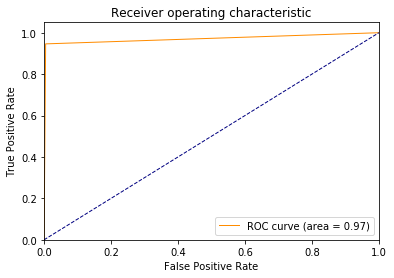

In [30]:
fpr, tpr, _ = roc_curve(y_SAT_test, y_SAT_score1 )
roc_auc = auc(fpr, tpr)
lw=1
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# SAT Model #2 : KNN Classifier

In [26]:
############################
C_NEIGHBORS = [4] 
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS, 
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=k_fold,n_jobs=-1, verbose=1 )

SAT_KNearest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score2 = grid_search.predict(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_score2))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.1s finished


0.79020930102412


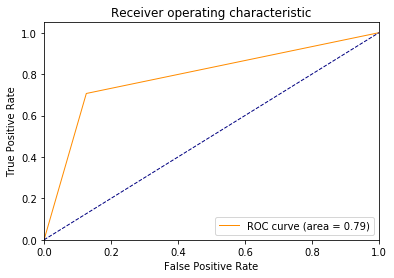

In [29]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_SAT_test, y_SAT_score2 )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# SAT Model #3 :  SVC Classifier

In [28]:
##########################
C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [SVC()],
         'clf__C': C_OPTIONS, 
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )

SAT_SVC_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score3 = grid_search.predict(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_score3))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.5min finished


0.928661368851083


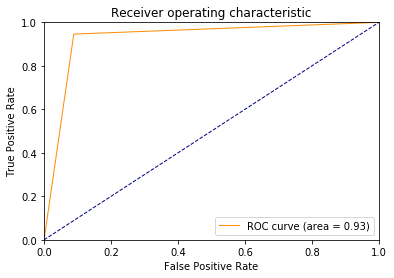

In [31]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_SAT_test, y_SAT_score3 )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
###############################################################################################

In [ ]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_RandomForest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_score))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.2s


In [18]:
print(crime_RandomForest_model.best_params_)
print(crime_RandomForest_model.multimetric_)

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'clf__max_depth': 5, 'clf__n_estimators': 50, 'reduce_dim__k': 'all'}
False


In [ ]:
C_NEIGHBORS = [5]
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS, 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_KNearest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_score = grid_search.predict(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_score))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [ ]:
print(crime_KNearest_model.best_params_)

# Reduced scope model

In [ ]:
X_crime_reduced = X_crime[X_crime.columns.drop(list(X_crime.filter(regex='[Aa]sian|[Hh]ispanic|[Rr]ace|[Bb]lack|[Mm]inority|[Tw]wo[Oo]r[Mm]ore|[Ii]ndian|[Ww]hite')))]
X_crime_reduced_train, X_crime_reduced_test, y_crime_reduced_train, y_crime_reduced_test = train_test_split(X_crime_reduced, y_crime, test_size=.2)

In [ ]:
print(X_crime_reduced.columns.values)

In [ ]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_reduced_GradientBoost_model = grid_search.fit(X_crime_reduced_train, y_crime_reduced_train)


y_crime_reduced_score = grid_search.predict(X_crime_reduced_test)

print(roc_auc_score(y_crime_reduced_test, y_crime_reduced_score))


In [ ]:
pipe.set_params(**crime_reduced_GradientBoost_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

In [ ]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 20 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

# 2.d Modeling and Evaluation
10 points - Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

In [ ]:
# #Run this to load the model from the save file

# from sklearn.externals import joblib
# grid_search = joblib.load('savedBestModel.pkl')


# # Loads all parameters run into a dict 

# params = np.array(grid_search.cv_results_['params'])


# # Loads all mean test scores into an array

# mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

In [ ]:
# # Assigns all models to an array

# classifier_labels=['SVC','LogisticRegression','SGDClassifier']


# # Creates an empty dataframe that is to be
# # filled with the mean test accuracy by C global
# # variable and the different classifiers

# classifier_temp = pd.DataFrame(columns=classifier_labels,index=C_OPTIONS,
#                                data=np.linspace(.1,.25,num=len(C_OPTIONS)*len(classifier_labels)).reshape(len(C_OPTIONS),len(classifier_labels)))
# classifier_temp.fillna(0,inplace=True)

# for i, (param, score) in enumerate(zip(params, mean_scores)):
#     C = param['clf__C'] if 'clf__C' in param else param['clf__alpha']
#     class_state = str(param['clf']).split('(')[0]
#     if classifier_temp.at[C,class_state] < score:
#         classifier_temp.at[C,class_state] = score


# # Printing a grid of the best accuracies
        
# display(classifier_temp.transpose())   


# # Print a line plot which shows the best 
# # accuracies
 
# classifier_temp.plot(logx=True,ylim=(0,1),figsize=(14,10),title='Accuracy by Classifier'); 

In [ ]:
# # Assigns all reduction models to an array

# reduce_labels=['NMF','PCA','SelectKBest']


# # Translates the N Features array
# # to an array full of string

# temp_N_FEATURES_OPTIONS = [str(r) for r in N_FEATURES_OPTIONS]
# temp_N_FEATURES_OPTIONS=temp_N_FEATURES_OPTIONS+['None']


# # Creates an empty dataframe that is to be
# # filled with the mean test accuracy by N Features
# # variable and the different feature reduction models

# reduce_temp = pd.DataFrame(columns=reduce_labels,index=temp_N_FEATURES_OPTIONS,
#                                data=np.linspace(.1,.25,num=len(temp_N_FEATURES_OPTIONS)*len(reduce_labels)).reshape(+len(temp_N_FEATURES_OPTIONS),len(reduce_labels)))


# for i, (param, score) in enumerate(zip(params, mean_scores)):
#     trigger=0
#     reduce_state = str(param['reduce_dim']).split('(')[0]
#     if 'reduce_dim__k' in param:
#         N_FEAT = str(param['reduce_dim__k'])
#         trigger=1
#     elif 'reduce_dim__n_components' in param:
#         N_FEAT = str(param['reduce_dim__n_components'])
#         trigger=1
#     else:
#         if reduce_temp.at['None','NMF'] < score:
#             reduce_temp.at['None','NMF'] = score
#             reduce_temp.at['None','SelectKBest'] = score
#     if trigger == 1:
#         if reduce_temp.at[N_FEAT,reduce_state] < score:
#             reduce_temp.at[N_FEAT,reduce_state] = score

            
# # Printing a grid of the best accuracies

# display(reduce_temp.transpose())


# # Print a bar plot which shows the best 
# # accuracies

# reduce_temp.plot(kind='bar',ylim=(0,1),figsize=(14,10),title='Accuracy by Feature Selection',rot=0);           

In [ ]:
# print('The Index of the best model is',grid_search.best_index_)
# print('The parameters of the best model is')
# display(grid_search.best_params_)
# print('The accuracy of the best model is',round(grid_search.best_score_*100,4))

# 2.e Modeling and Evaluation
10 points - Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference signiﬁcant with 95% conﬁdence? Use proper statistical comparison methods.

# 2.f Modeling and Evaluation
10 points - Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classiﬁcation task.

# Deployment
5 points - How useful is yolur model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

# Exceptional Work
10 points - You have free reign to provide additional modeling. 
One idea: grid search parameters in a parallelized fashion and visualize the 
performances across attributes. Which parameters are most signiﬁcant for making a 
good model for each classiﬁcation algorithm?